# Dynamical Decoupling and Randomized Benchmarking on 2 qubit

## Setup

In [2]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from qutip import *

import qutip_qip
from qutip_qip.circuit import QubitCircuit
from qutip.qip.operations import *
from qutip.qip.operations.gates import *
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import Model, ModelProcessor, Processor
from qutip_qip.noise import Noise
from qutip.qip.noise import RandomNoise # for Gaussian noise
from qutip.qip.pulse import Pulse
from qutip.qip.gates import *

from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

import functools # for reduce
from joblib import Parallel, delayed  # for parallel simulations
import itertools # for RB inverse search

import os
import os.path

C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_12828\958140696.py:17: DeprecationWarning: Importation from qutip.qip.gates is deprecated.Please use e.g.
 from qutip.qip.operations import cnot

  from qutip.qip.gates import *


In [3]:
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
with open("rename.py") as f:
    exec(f.read())

## Customize device

Parameters

In [5]:
VStd = 0.01
phaseStd = 0.382 / 180 * np.pi

detuningStd = 52769
samplingRate = 5898.24e6 # 5.89824 GS/s
omega = 20e6 # 20MHz

VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46

V = VNaught + np.random.normal(scale=VStd)
phi = phiNaught + np.random.normal(scale=phaseStd)
I = np.cos(phi)
Q = np.sin(phi)

# Decoherence time
T1 = 8.66e-6
T1_err = 0.49
T2 = 9.08e-6
T2_err = 0.74e-6
T2_echo = 16.14e-6
T2_echo_err = 3.21e-6

# Initial condition
psi0 = basis(2,0)
t_0 = 0

# Pi pulse duration from earlier runs
pi_pulse_duration = np.loadtxt('pulse_duration.txt')[0]
pi_half_pulse_duration = np.loadtxt('pulse_duration.txt')[1]

Built a Hamiltonian model for a device with 2 single qubit control: $\sigma_x$ and $\sigma_y$

In [96]:
class MyProcessor(ModelProcessor):
    """
    Custom processor built using ModelProcessor as the base class.
    This custom processor will inherit all the methods of the base class
    such as setting up of the T1 and T2 decoherence rates in the simulations.

    Args:
        num_qubits (int): Number of qubits in the processor.
        t1, t2 (float or list): The T1 and T2 decoherence rates for the
    """

    def __init__(self, num_qubits, t1=None, t2=None):
        # call the parent class initializer
        super(MyProcessor, self).__init__(num_qubits, t1=t1, t2=t2)  
        # The control pulse is discrete or continous.
        self.pulse_mode = "discrete"
        # The dimension of each controllable quantum system
        self.model.dims = [2] * num_qubits
        self.num_qubits = num_qubits
        self.set_up_ops()  # set up the available Hamiltonians

    def set_up_ops(self):
        """
        Sets up the control operators.
        """
        # sigmax pulse on m-th qubit with the corresponding pulse
        for m in range(self.num_qubits):
            self.add_control(2 * np.pi * sigmax(), m, label="sx" + str(m))
        # sy
        for m in range(self.num_qubits):
            self.add_control(2 * np.pi * sigmay(), m, label="sy" + str(m))
    
    # To remove some errors
    def add_noise(self, noise):
        """
        Add a noise object to the processor

        Parameters
        ----------
        noise: :class:`.Noise`
            The noise object defined outside the processor
        """
        self.noise.append(noise)


Define the compiling routines for the two types of rotation gates RX and RY with the driving Hamiltonian:

\begin{equation}
    \mathcal{H} = \Omega V_0 s(t) ( (-I\cos{(\delta \omega t)} + Q\sin{(\delta \omega t)})\sigma_x + (I\sin{(\delta \omega t)}-Q\cos{(\delta \omega t)})\sigma_y)
\end{equation}

In [141]:
class MyCompiler(GateCompiler):
    """
    Custom compiler for generating pulses from RX and RY gates using the base class GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses
                       such as the pulse amplitude.
    """
    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {
            "RX": self.single_qubit_gate_compiler,
            "RY": self.single_qubit_gate_compiler,
            "SF": self.spin_flip_gate_compiler,
        }

    def single_qubit_gate_compiler(self, gate, args):
        """Compiles single-qubit gates to pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
            (Note: Instruction class includes args:
                tlist (array): A list of times for the evolution.
                coeff (array): An array of coefficients for the gate pulses
            )

        """
        if gate.name == "RX" or gate.name == "RY":
            # Rotation angle
            phiNaught = gate.arg_value[1]
            
            # Parameters
            V = VNaught + np.random.normal(scale=VStd)
            phi = phiNaught + np.random.normal(scale=phaseStd)
            I = np.cos(phi)
            Q = np.sin(phi)

            # Find tlist (list of time steps) for pi pulse or pi-half pulse
            ratio_of_pi_pulse = gate.arg_value[0]
            if ratio_of_pi_pulse == 0.5:
                n_steps = int(samplingRate * (pi_pulse_duration/2 - t_0))
                tlist = np.linspace(t_0, pi_pulse_duration/2, n_steps) 
            else:
                n_steps = int(samplingRate * (pi_pulse_duration - t_0))
                tlist = np.linspace(t_0, pi_pulse_duration, n_steps)        

            # Find coeff for sigma x and sigma y (from Hamiltonian)
            dwt = np.random.normal(scale=detuningStd) * tlist
            s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * tlist / pi_pulse_duration)

            coeff_x = np.asarray([omega * np.pi * V * s[i] * (-I * np.cos(dwt[i]) + Q * np.sin(dwt[i])) for i in range(len(s))])
            coeff_y = np.asarray([omega * np.pi * V * s[i] * (I * np.sin(dwt[i]) - Q * np.cos(dwt[i])) for i in range(len(s))])

            pulse_info = [
                # (control label, coeff)
                ("sx" + str(gate.targets[0]), coeff_x),
                ("sy" + str(gate.targets[0]), coeff_y),
            ]
            return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]

    def spin_flip_gate_compiler(self, gate, args):
        n_steps = int(samplingRate * (pi_pulse_duration/2 - t_0))
        tlist = np.linspace(t_0, pi_pulse_duration/2, n_steps) 
        tlist = tlist/10
        coeff = 0 * tlist + 1
        phase = gate.arg_value[0]
        pulse_info = [  ("sx" + str(gate.targets[0]), np.cos(phase) * coeff),
                        ("sy" + str(gate.targets[0]), np.sin(phase) * coeff),]
        return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]
        

Define an example circuit.

In [144]:
def spin_flip(phi, N = None, target = 1):
    return rx(phi, N = None, target = 1)

In [145]:
# Define a circuit and run the simulation
num_qubits = 2
circuit = QubitCircuit(num_qubits)
init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)
circuit.user_gates = {"SF": spin_flip(phi = np.pi)}
# Gates
circuit.add_gate(Gate("RX", 0, arg_value=[0,0])), # X Pulse
circuit.add_gate(Gate("RY", 0, arg_value=[0,np.pi / 2])), # Y Pulse
circuit.add_gate(Gate("RX", 0, arg_value=[0.5,0])), # X Half Pulse
circuit.add_gate(Gate("RY", 0, arg_value=[0.5,np.pi / 2])), # Y Half Pulse
circuit.add_gate(Gate("RX", 0, arg_value=[0.5,-np.pi])), # X Minus Half Pulse
circuit.add_gate(Gate("RY", 0, arg_value=[0.5,-np.pi / 2])), # Y Minus Half Pulse
circuit.add_gate(Gate("SF", 1, arg_value = [np.pi]))

myprocessor = MyProcessor(num_qubits)
mycompiler = MyCompiler(num_qubits,{})
myprocessor.load_circuit(circuit, compiler=mycompiler)

# Gaussian noise
n_steps = int(samplingRate * (pi_pulse_duration - t_0))
tlist = np.linspace(t_0, pi_pulse_duration, n_steps)
gaussnoise = RandomNoise(dt=100*tlist[1], indices = [0,1], rand_gen=np.random.normal, loc=0.00, scale=0.3)
myprocessor.add_noise(gaussnoise)
result = myprocessor.run_state(init_state)
print(fidelity(result.states[-1], init_state))
print(init_state,result.states[-1])

0.4141872588072636
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]] Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-6.50126405e-02+4.09053104e-01j]
 [-4.91257649e-07-7.80698592e-08j]
 [ 3.51912771e-01-8.39408313e-01j]
 [ 1.00808130e-06+4.22647070e-07j]]


C:\Users\XPS13-9360\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qutip_qip\device\processor.py:844: UserWarning: No method get_control_latex defined in the model. Switch to using the labels defined in each pulse.Set use_control_latex=False to turn off the warning.
  warnings.warn(


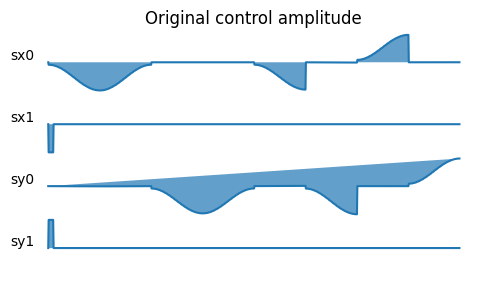

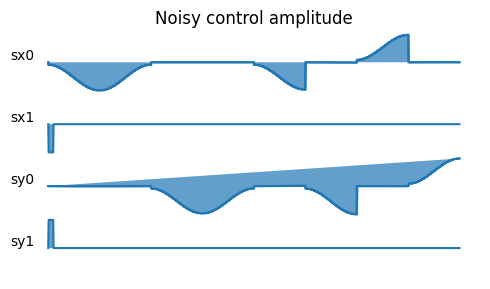

In [146]:
# Ignore the shading
# Plot the ideal pulse
fig1, axis1 = myprocessor.plot_pulses(title="Original control amplitude", figsize=(5,3))

# Plot the noisy pulse
qobjevo, _ = myprocessor.get_qobjevo(noisy=True)
noisy_coeff0 = qobjevo.to_list()[1][1] + qobjevo.to_list()[2][1]
noisy_coeff1 = qobjevo.to_list()[3][1] + qobjevo.to_list()[4][1]
fig2, axis2 = myprocessor.plot_pulses(title="Noisy control amplitude", figsize=(5,3))
axis2[0].step(qobjevo.tlist, noisy_coeff0)
axis2[2].step(qobjevo.tlist, noisy_coeff1)

## Randomized Benchmarking

Simulation for a random circuit

In [10]:
gates_set = [
    Gate("RX", 0, arg_value=[0,np.pi]), # X Pulse
    Gate("RY", 0, arg_value=[0,np.pi / 2]), # Y Pulse
    Gate("RX", 0, arg_value=[0.5,0]), # X Half Pulse
    Gate("RY", 0, arg_value=[0.5,np.pi / 2]), # Y Half Pulse
    Gate("RX", 0, arg_value=[0.5,-np.pi]), # X Minus Half Pulse
    Gate("RY", 0, arg_value=[0.5,-np.pi / 2]), # Y Minus Half Pulse
]

matrix_list = [
    rx(np.pi), # X
    ry(np.pi), # Y,
    rx(np.pi / 2), # X/2
    ry(np.pi / 2), # Y/2
    rx(-np.pi / 2), # -X/2
    ry(-np.pi / 2), # -Y/2
    rx(0)
]

In [11]:
def inverse_search(state_after_clifford,matrix_list,ground_state):
    # Index of 2 gates that inverse the clifford sequence
    index_list = [i for i in itertools.product(range(len(matrix_list)), range(len(matrix_list)))]
    # Product of said 2 gates
    inverse_list = [i[0]*i[1] for i in itertools.product(matrix_list, matrix_list)]
    
    for i in range(len(inverse_list)):
        # Find final state after applying the 2 inverse gates and "normalize"
        final_state = inverse_list[i] * state_after_clifford
        if final_state[0][0][0] == 0:
            final_state = final_state/final_state[1][0][0]
        else:
            final_state = final_state/final_state[0][0][0]
        # Compare to ground state
        if np.allclose(final_state,ground_state):
            return index_list[i]

In [62]:
def single_simulation(num_gates, T1 = None, T2 = None, num_qubits = 1 , gaussian_noise = True):
    """
    A single simulation, with num_gates representing the number of rotations.

    Args:
        num_gates (int): The number of random gates to add in the simulation.

    Returns:
        result (qutip.solver.Result):
            A qutip Result object obtained from any of the
            solver methods such as mesolve.
    """
    myprocessor = MyProcessor(num_qubits,t1=T1,t2=T2)
    myprocessor.native_gates = None  # Remove the native gates
    mycompiler = MyCompiler(num_qubits,{})
    
    # Ground state for n qubits
    init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

    # Define a random circuit.
    circuit = QubitCircuit(num_qubits)
    clifford = rx(0)
    for ind in np.random.randint(0, 6, num_gates):
        circuit.add_gate(gates_set[ind])
        clifford = clifford * matrix_list[ind]
    
    # Finding inverse Clifford for the random sequence of gate
    x = inverse_search(clifford*init_state,matrix_list,init_state)
    if x == None:
        raise RuntimeError("Could not find an inverse Clifford")
    elif not x[0] == 6 and not x[1] == 6:
        circuit.add_gate(gates_set[x[1]])
        circuit.add_gate(gates_set[x[0]])
    elif x[0] == 6 and not x[1] == 6:
        circuit.add_gate(gates_set[x[1]])
    elif x[1] == 6 and not x[0] == 6:
        circuit.add_gate(gates_set[x[0]])
    
    # Simulate the circuit.
    myprocessor.load_circuit(circuit, compiler=mycompiler)

    # Gaussian noise
    if gaussian_noise == True:
        n_steps = int(samplingRate * (pi_pulse_duration - t_0))
        tlist = np.linspace(t_0, pi_pulse_duration, n_steps)
        gaussnoise = RandomNoise(dt=100*tlist[1], indices = [0,1], rand_gen=np.random.normal, loc=0.00, scale=0.3)
        myprocessor.add_noise(gaussnoise)

    # Compute results of the run using a solver of choice
    result = myprocessor.run_state(init_state, solver="mesolve")
    
    # Measured fidelity at the end
    final_fidelity = fidelity(result.states[0],result.states[-1])
    return final_fidelity

The simulation is repeated 20 times to obtain average fidelity

os.remove("fidelity_average.txt")
os.remove('fidelity_error.txt')
if os.path.isfile('./fidelity_average.txt') == True:
    print('Exist file')
    fidelity_average = np.loadtxt('fidelity_average.txt').tolist()
    fidelity_error = np.loadtxt('fidelity_error.txt').tolist()
else:
    print('File not found')
    fidelity_average = []
    fidelity_error = []

In [65]:
# For num_sample = 20, takes about 4 min
num_sample = 20
#num_gates_list = np.linspace(1,300,25,dtype=int)
num_gates_list = np.arange(5,105,10)
fidelity_average = []
fidelity_error = []

for num_gates in num_gates_list:
    fidelity_list = [single_simulation(num_gates, gaussian_noise = False) for i in range(num_sample)]
    fidelity_average.append(np.mean(fidelity_list))
    fidelity_error.append(np.std(fidelity_list) / np.sqrt(num_sample))
    print(num_gates)

5
15
25
35
45
55
65
75
85
95


Text(0, 0.5, 'Ground State Fidelity')

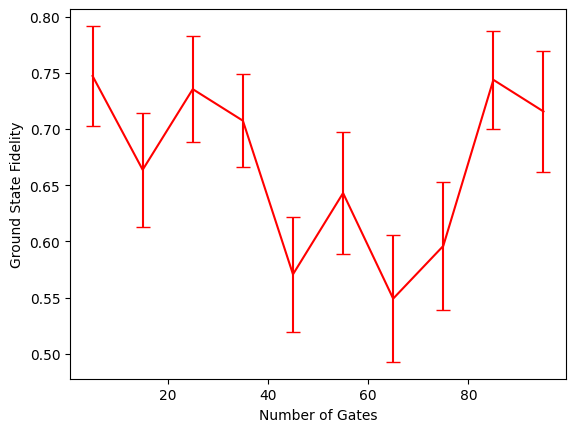

In [66]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.errorbar(num_gates_list, fidelity_average, yerr=fidelity_error, color='red', capsize=5)
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")

## Dynamical decoupling

ZZ crosstalk

In [84]:
class ZZ_crosstalk(Noise):
    def __init__(self, strength):
        self.strength = strength

    def get_noisy_dynamics(self, dims, pulses, systematic_noise):
        zz_operator = tensor([sigmaz(), sigmaz()])
        for i in range(len(dims) - 1):
            systematic_noise.add_control_noise(self.strength * zz_operator, targets=[i, i + 1], tlist=tlist, coeff=True)

crosstalk_noise = ZZ_crosstalk(strength=1)

0.07523180446594378
0.4283508451946334


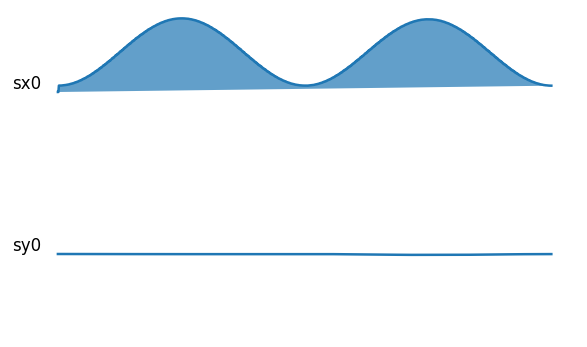

In [85]:
myprocessor = MyProcessor(num_qubits,t1=T1,t2=T2)
myprocessor.native_gates = None  # Remove the native gates
mycompiler = MyCompiler(num_qubits,{})

# Ground state for n qubits
init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

# Define a random circuit.
circuit = QubitCircuit(num_qubits)
circuit.add_gate(gates_set[0])
circuit.add_gate(gates_set[0])

# Simulate the circuit.
myprocessor.load_circuit(circuit, compiler=mycompiler)
result = myprocessor.run_state(init_state, solver="mesolve")
final_fidelity = fidelity(result.states[0],result.states[-1])
print(final_fidelity)

# Gaussian noise
n_steps = int(samplingRate * (pi_pulse_duration - t_0))
tlist = np.linspace(t_0, pi_pulse_duration, n_steps)
gaussnoise = RandomNoise(dt=100*tlist[1], indices = [0,1], rand_gen=np.random.normal, loc=0.00, scale=0.3)
myprocessor.add_noise(gaussnoise)

# ZZ noise
myprocessor.add_noise(crosstalk_noise)

myprocessor.load_circuit(circuit, compiler=mycompiler)
result = myprocessor.run_state(init_state, solver="mesolve")
final_fidelity = fidelity(result.states[0],result.states[-1])
print(final_fidelity)
fig, ax = myprocessor.plot_pulses(figsize=(5, 3), dpi=120, use_control_latex=False,rescale_pulse_coeffs=False)